# Documentation

## Things to explore
1. Why is the temperature response so similar between the two scenarios? (including power spectra)
2. Looking at partition of MSE between LH and SH, track these over time
--> Save specific humidity over time
3. Refactor noise from autocorrelation into an e-folding time
4. Also adjust heat capacity of land to be more accurate
5. Longer term - add in other parameterizations (ice, etc.)
6. Fix permission issues with saving


# Imports

In [2]:
import numpy as np
import scipy as sp
import xarray as xr
import scipy.io as io
from scipy.signal import welch
from scipy.interpolate import griddata
from scipy.stats import f
import matplotlib.pyplot as plt
from matplotlib import colors

# Define Parameters & Constants

## Simulation Parameters

Specify a number of parameters that affect what simulation is run

In [3]:
## Whether to save output to NetCDF file
save_output = True

## How often to save otuputs
save_frequency = 'weekly' # options are 'monthly', 'biweekly', or 'weekly'

## Specify a climatology
# climatology = 'CMIP5-4xCO2'
climatology = 'ERA-Interim'

## Noise parameters
noise_color = 'white' # options are 'no', 'white', or 'red'
noise_amplitude = 10 # units of W m^-2
noise_seed = 0
red_noise_autocorrelation = 0.95 # only used if noise_color='red'

## Level of statistical significance for regional variability
p_critical = 0.95

## Temporal parameters

In [4]:
# Specify time step
delt=1./(4*24*365) # 4 15-minute chunks per hour * 24 hours per day * 365 days per year
# delt=1./34560 # 34560 corresponds to a 15 minute timestep

# Specify number of years to simulate
n_years = 5

# Calculate number of total iterations
NMAX = int(n_years*(1/delt)) # number of time steps

# Number of iterations
year_step = int(1/delt)     # per year
month_step = year_step//12   # per month

# Number of 30-day months in the simulation
n_months = NMAX//month_step

# Number of iterations per save
if save_frequency == 'yearly':
    save_step = year_step # save once a year - for very long simulations
elif save_frequency == 'monthly':
    save_step = month_step # save every month
elif save_frequency == 'biweekly':
    save_step = month_step//2 # save every 2 weeks
elif save_frequency == 'weekly':
    save_step = month_step//4 # save weekly

# Number of iterations that will be saved
n_saves = NMAX//save_step

## Spatial parameters

In [5]:
# Number of latitude points 
jmx=101
delx = 2.0/jmx

# set up x array (x = sine of latitude)
x = np.arange(-1.0+delx/2,1.0,delx)

# latitude
phi = np.arcsin(x)*180/np.pi

## Physical Constants

In [6]:
# Moisture parameters
relhum = 0.8   # relative humidity
eps = 0.622    # moisture constant
psfc = 9.8e4   # (Pa)
e0 = 611.2     # vap. press (Pa)
a = 17.67
b = 243.5   # sat vap constants, T must be in temperature!!
L = 2.45e6         # latent heat of vaporization (J kg-1)
cp = 1004          # (J kg-1 K-1)

# I think this C = rho * c * h_ml /(pi*1e7).
# this is consistent with a ~1m layer of dirt
# Note - heat capacity over LAND for fast convergence
Cl = 0.2 # units: J /(m2 K)

# magnitude of diffusivity
Dmag = 0.2598 # D = 0.2598 W/(m2 K) is the value used by TF10 
D=Dmag*np.ones(jmx+1) # diffusivity for MSE

In [7]:
# For dry energy balance model, uncomment these lines:
#Dmag = 0.44; # magnitude of diffusivity [W/(m2 K)]
#D=Dmag*np.ones(jmx+1); # diffusivity for sensible (cp*T)
#relhum = 0;  # switch off humidity

# Define Radiative Forcings and Feedbacks

1. Lambda (Radiative Feedback Param)
2. G (ocean heat uptake)
3. F (radiative forcing)

## CMIP5

CMIP5 ensemble-mean feedback and forcing values from 4xCO2 simulations (taken at year 100)

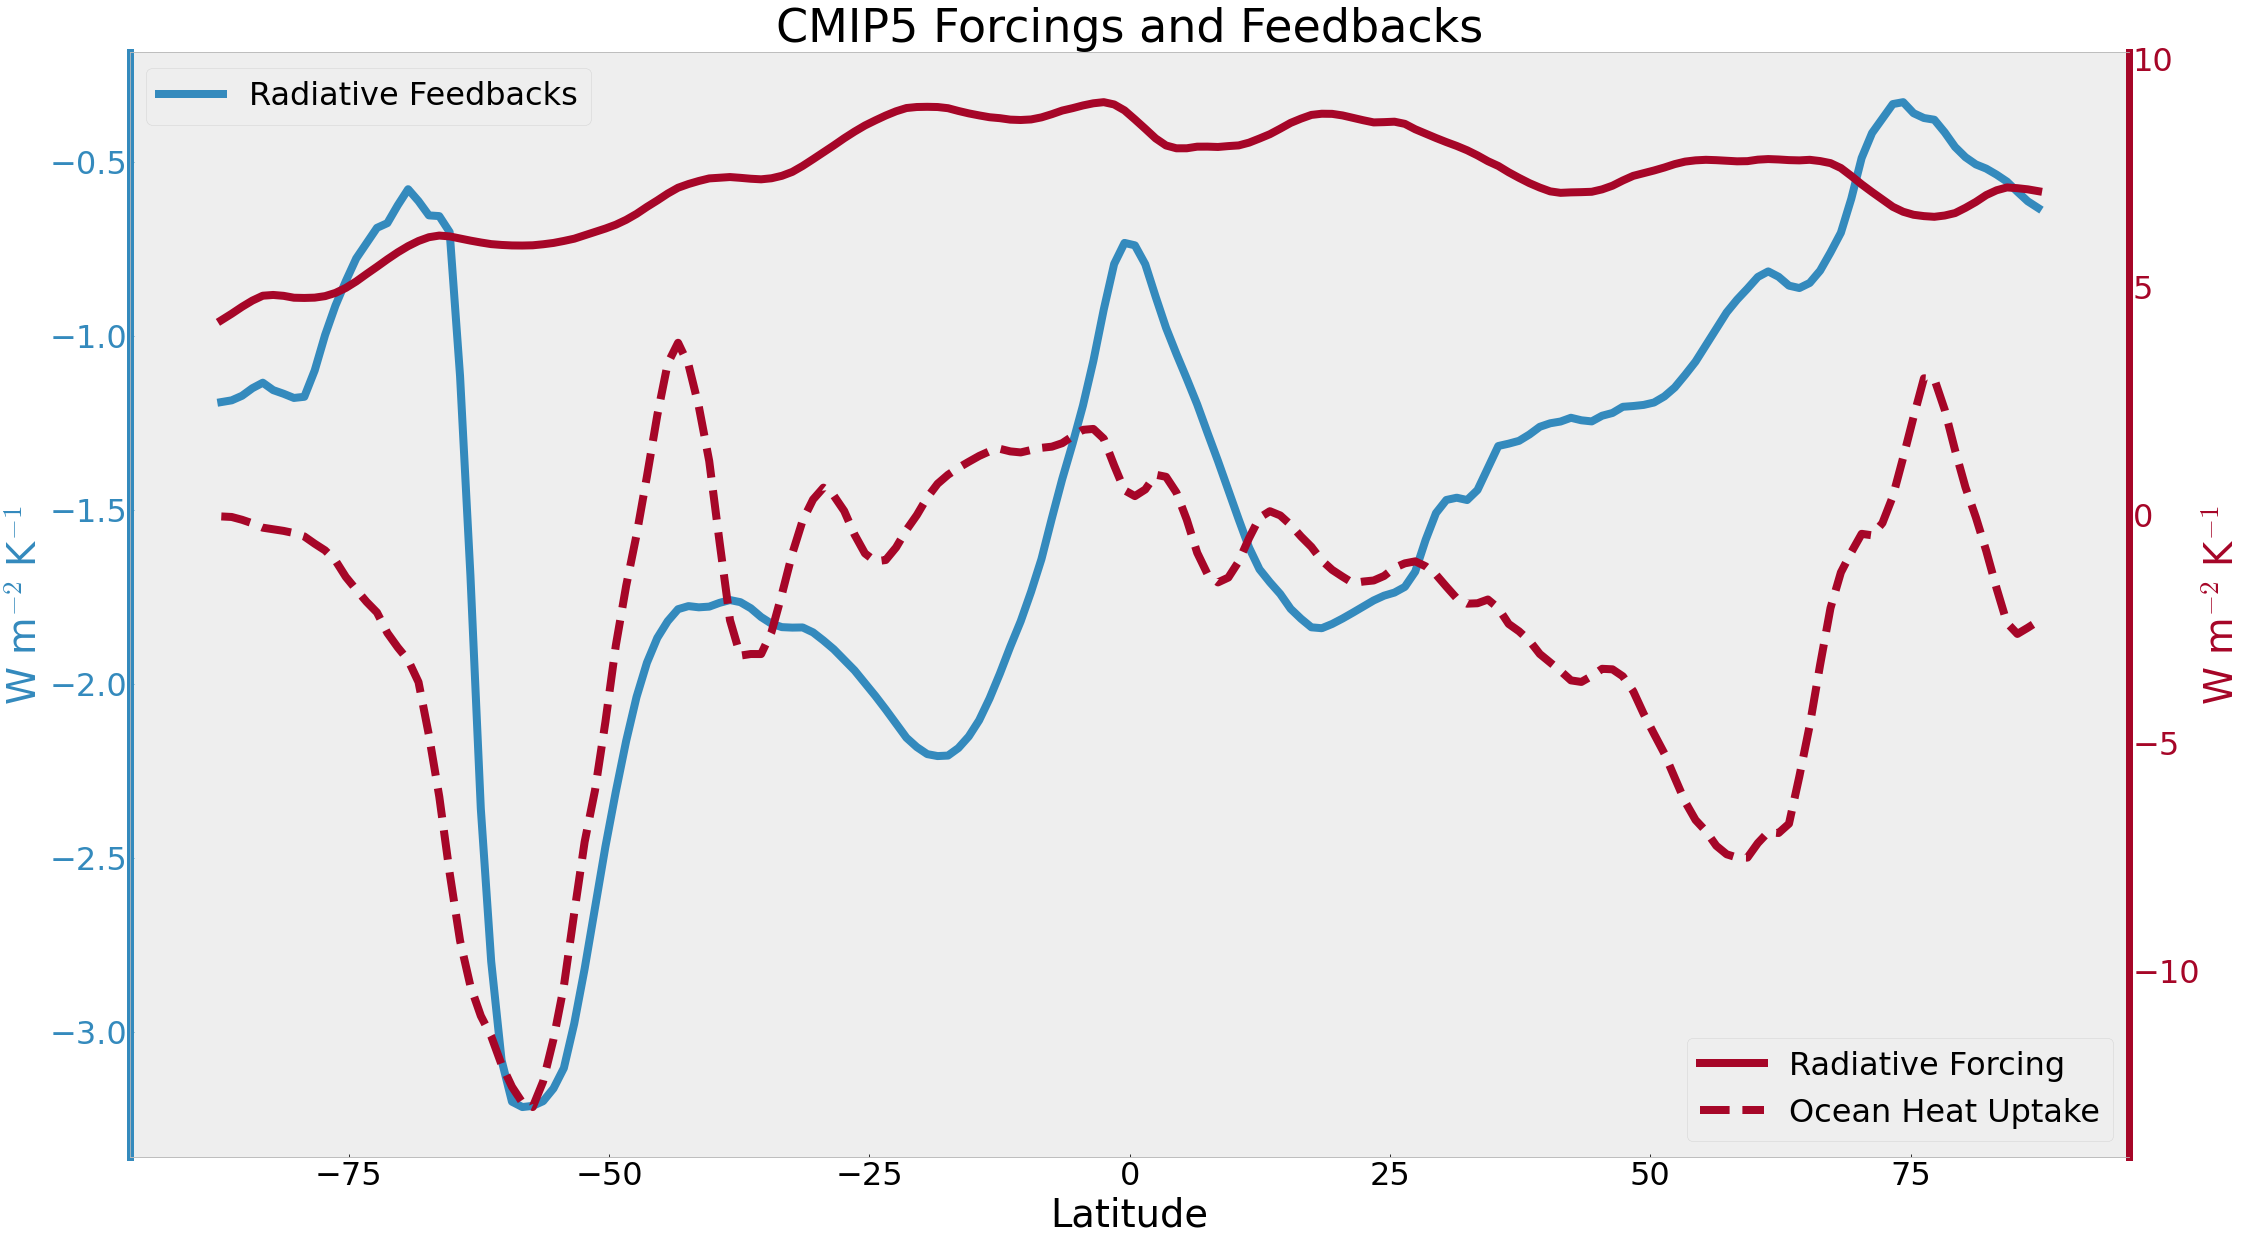

In [8]:
# Feedback, forcing and heat uptake for 11 models
matLabData = io.loadmat('CMIP5_Rf_G_lambda.mat') 

# Latitude
CMIP5_lat = np.asarray(matLabData['CMIP5_lat']) 

# Temperature change
CMIP5_T = np.asarray(matLabData['CMIP5_T']) 

# Radiative feedback
CMIP5_lambda = np.asarray(matLabData['CMIP5_lambda']) 

# Radiative forcing
CMIP5_Rf = np.asarray(matLabData['CMIP5_Rf']) 

# Ocean heat uptake
CMIP5_G = np.asarray(matLabData['CMIP5_G']) 

# Model names
CMIP5_names = np.asarray(matLabData['CMIP5_names']) 

# Regrid B (radiative feedback parameter), R (radiative forcing), G (ocean heat uptake)
# and take average over the 13 CMIP5 models

# Radiative feedbacks
B = -griddata(
    CMIP5_lat,np.mean(
        CMIP5_lambda,axis=1),
    phi, 
    method='linear'
) 

# Radiative forcing
R_frc = griddata(
    CMIP5_lat,np.mean(
        (CMIP5_Rf + CMIP5_G),
        axis=1),
    phi, 
    method='linear'
) #CO2 forcing Rf plus ocean heat uptake G

# Ocean heat uptake (needed for Evaporation below)
G_frc = griddata(
    CMIP5_lat,np.mean(
        CMIP5_G,axis=1),
    phi, 
    method='linear'
) 

# Plot spatial pattern of forcing and feedbacks
plt.style.use('bmh')
plt.rcParams.update({'font.size':32})
plt.figure(figsize=(32,18))
plt.plot(
    CMIP5_lat,
    np.mean(CMIP5_lambda,axis=1), 
    color='#348ABD', 
    lw=8, 
    label='Radiative Feedbacks'
)
plt.title('CMIP5 Forcings and Feedbacks')
plt.xlabel('Latitude')
plt.ylabel(r"W m$^{-2}$ K$^{-1}$", color='#348ABD')
plt.gca().tick_params(axis='y', colors='#348ABD')
plt.gca().spines['left'].set_color('#348ABD')
plt.gca().spines['left'].set_linewidth(7)
plt.gca().grid(False)
plt.legend(loc='upper left')

plt.twinx()
plt.plot(
    CMIP5_lat, 
    np.mean(CMIP5_Rf,axis=1), 
    color='#A60628', 
    lw=8, 
    label='Radiative Forcing'
)
plt.plot(
    CMIP5_lat,
    np.mean(CMIP5_G,axis=1),
    color='#A60628',
    ls = '--', 
    lw=8, 
    label='Ocean Heat Uptake'
)

plt.ylabel(r"W m$^{-2}$ K$^{-1}$", color='#A60628')
plt.gca().tick_params(axis='y', colors='#A60628')
plt.gca().spines['right'].set_color('#A60628')
plt.gca().spines['right'].set_linewidth(7)
plt.gca().grid(False, axis='x')
plt.gca().grid(False, axis='y')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

## Uniform

In [9]:
# For flat forcing, uniform feedbacks, no ocean heat uptake, uncomment these lines:
#R_frc = 7.8; # uniform forcing in [W/m2] for a quadrupling of CO2, 7.8 value taken as global average of CMIP5
#G_frc = 0; #no ocean heat uptake
#B = 1.4*np.ones(x.size) # uniform feedback [W/m2/K], 1.4 value taken as average of CMIP5
#print('Using flat forcing and feedbacks instead of CMIP5!!')

# Define Divergence Matrix

In [10]:
#Create matrix to take a divergence of something it acts on   
#set up lambda array.
lam=(1-np.square(np.arange(-1.0,1.0+delx,delx)))/np.square(delx);
lam=np.multiply(D, lam); 

M = np.zeros((jmx,jmx));

M[0,0] =  - lam[1];
M[0,1] = lam[1];

M[jmx-1,jmx-2] = lam[jmx-1];
M[jmx-1,jmx-1]   = - lam[jmx-1];

for j in range(1, jmx-1): 
    M[j,j-1] = lam[j]
  
    M[j,j]   = - (lam[j+1]+lam[j])
  
    M[j,j+1] = lam[j+1]

# Divergence matrix 
Mdiv = M 

# Define Climatology

## ERA-Interim

1. Load zonal mean temperature from ERA5-Interim (matLabData)
2. Interpolate the climatology to be same resolution as x

In [11]:
if climatology == 'ERA-Interim':
    # load in the climatological temperature from ERA-Interim for the control climate
    matLabData = io.loadmat('ERAtemperature.mat') 
    
    # Assign variables
    lat = np.asarray(matLabData['lat'])
    T_ctrl = np.asarray(matLabData['T'])
    print("Initial T control shape: ", T_ctrl.shape) 
    
    # uncomment this line to symmetrize the assumed climatological temperature
    # T_ctrl = 0.5*(T_ctrl+np.flipud(T_ctrl)); # average N & S hemispheres for symmetry
    
    # Regrid data to match x
    T_ctrl = griddata(np.sin(np.deg2rad(lat)), T_ctrl, x, method='linear') 
    T_ctrl = np.squeeze(T_ctrl, axis=1)
    print("Regridded T control shape: ", T_ctrl.shape) 

    # Calculate climatological specific humidity 
    # here T is in °C. q is g kg-1
    q_ctrl = eps*relhum/psfc*e0*np.exp(a*(T_ctrl)/(b+(T_ctrl)))
    
    # Calculate climatological MSE in temperature units (Kelvin)
    theta_e_ctrl = 1/cp*(cp*((T_ctrl)+273.15) + L*q_ctrl) 

Initial T control shape:  (73, 1)
Regridded T control shape:  (101,)


## CMIP5 4xCO2

1. Load zonal mean temperature from CMIP6 
2. Interpolate the climatology to be same resolution as x

In [12]:
if climatology == 'CMIP5-4xCO2':
    
    # load in the climatological temperature from ERA-Interim for the control climate
    matLabData = io.loadmat('ERAtemperature.mat') 
    
    # Assign variables
    lat = np.asarray(matLabData['lat'])
    T_ctrl = np.asarray(matLabData['T'])
    
    # Regrid data to match x
    T_ctrl = griddata(np.sin(np.deg2rad(lat)), T_ctrl, x, method='linear') 
    T_ctrl = np.squeeze(T_ctrl, axis=1)
    
    # Calculate warming from CMIP5 4xCO2 scenario
    T_warm = np.mean(CMIP5_T, axis=1)
    T_warm = T_warm.reshape((T_warm.shape[0], 1))
    print("Initial T control shape: ", T_ctrl.shape) 
    
    # uncomment this line to symmetrize the assumed climatological temperature
    # T_ctrl = 0.5*(T_ctrl+np.flipud(T_ctrl)); # average N & S hemispheres for symmetry
    
    # Regrid data to match x
    T_warm = griddata(np.sin(np.deg2rad(lat)), T_warm, x, method='linear') #interp1(sind(lat),T_ctrl,x,'linear');
    T_warm = np.squeeze(T_warm, axis=1)

    # Add CMIP5 warming to ERA-Interim climatology
    T_ctrl = T_ctrl + T_warm
    print("Regridded T control shape: ", T_ctrl.shape) 
    
    # Calculate climatological specific humidity 
    # here T is in °C. q is g kg-1
    q_ctrl = eps*relhum/psfc*e0*np.exp(a*(T_ctrl)/(b+(T_ctrl)))
    
    # Calculate climatological MSE in temperature units (Kelvin)
    theta_e_ctrl = 1/cp*(cp*((T_ctrl)+273.15) + L*q_ctrl) 

# Define Noise

Random Noise Seed: 0 



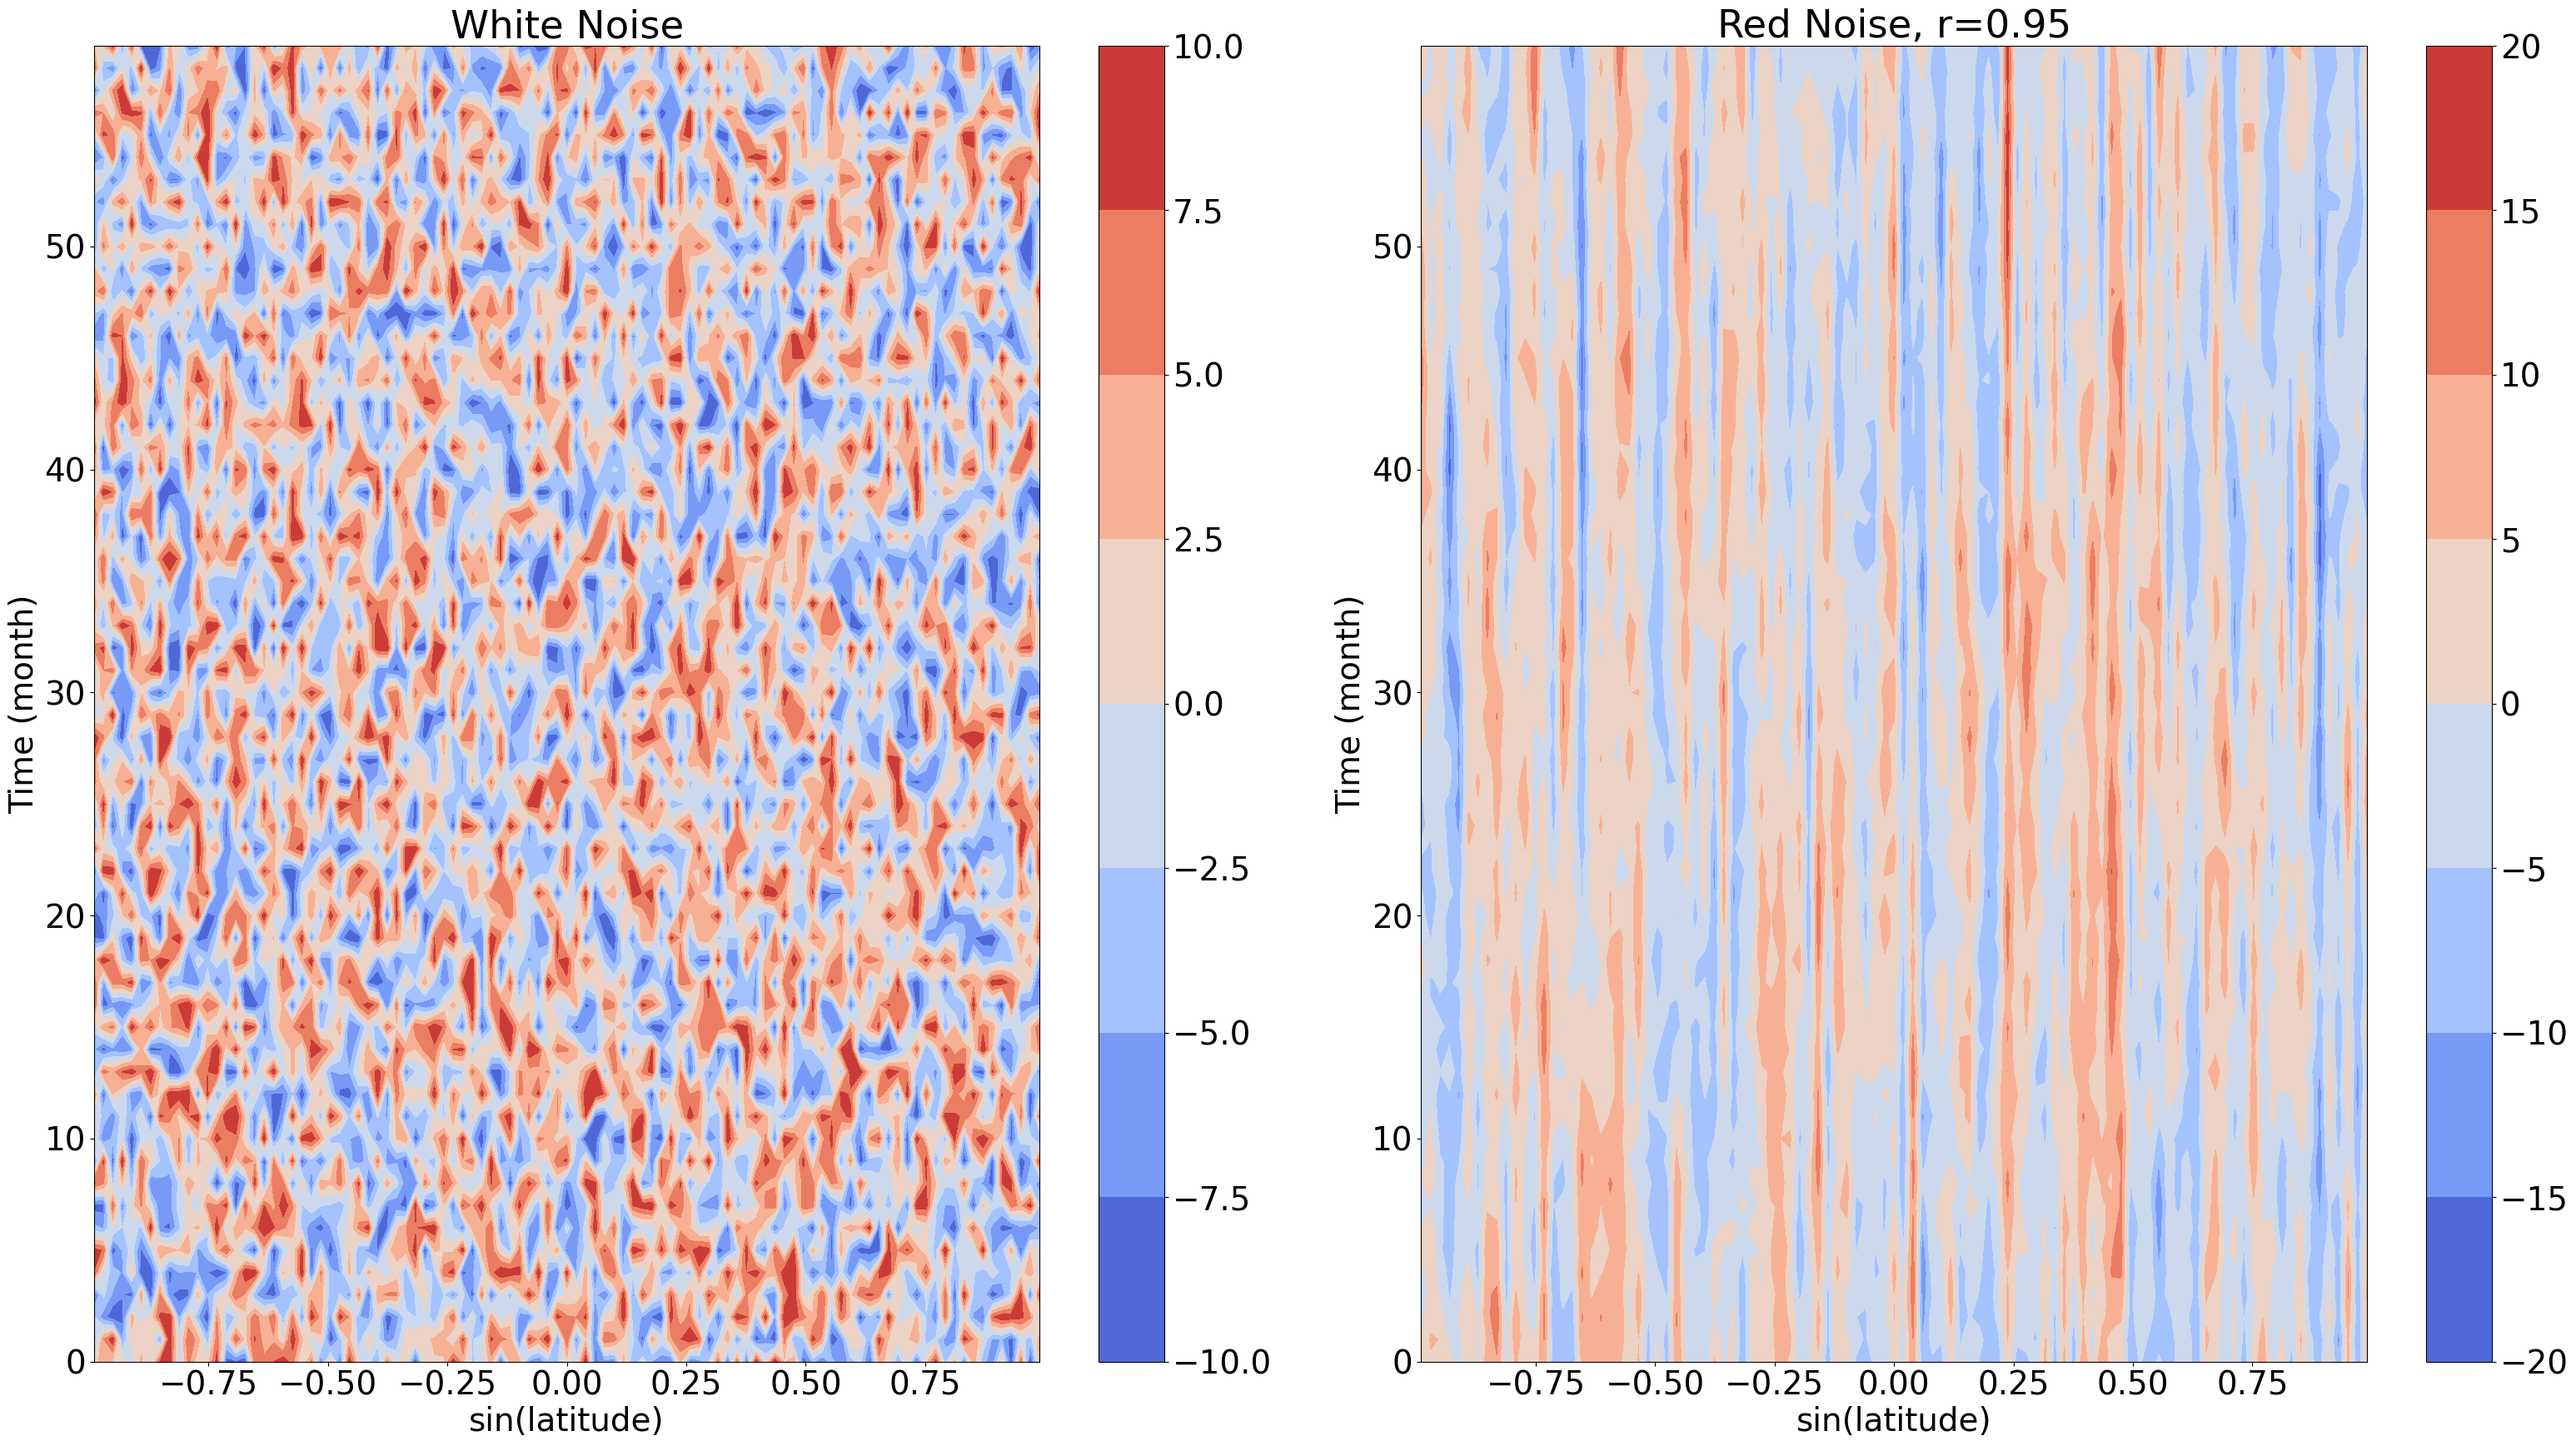

In [14]:
# Choose a random seed to get repeatable simulations
np.random.seed(noise_seed)
print(f"Random Noise Seed: {noise_seed} \n")

# Create a monthly time array 
months = np.arange(n_months)

# Generate white noise at each month and latitude point
white_noise = noise_amplitude*np.random.uniform(-1, 1, size=(n_months, jmx))

# Calculate red noise from white noise
red_noise = np.empty_like(white_noise)
red_noise[0] = white_noise[0]
for i in range(len(months)-1):
    red_noise[i+1] = (
        red_noise_autocorrelation*red_noise[i] 
        + np.sqrt((1-red_noise_autocorrelation**2))*white_noise[i+1]
    )

# Red noise that grows with time
# growing_red_noise = np.empty_like(white_noise)
# growing_red_noise[0] = white_noise[0]
# for i in range(len(months)-1):
#     growing_red_noise[i+1] = (5/(1+np.exp(-0.001*i)))
#         + (r*growing_red_noise[i] + np.sqrt((1-r**2))*white_noise[i+1])
    
# Set noise to be used in simulation
if noise_color == 'no':
    noise = np.zeros_like(white_noise)
elif noise_color == 'white':
    noise = white_noise
elif noise_color == 'red':
    noise = red_noise
    
# Plot generated noise as a function of month and latitude
plt.style.use('default')
plt.rcParams.update({'font.size':28})
[fig, ax] = plt.subplots(1,2, figsize=(32,18))
im0 = ax[0].contourf(x, months, white_noise, cmap='coolwarm', norm=colors.CenteredNorm())
ax[0].set_title('White Noise')
ax[0].set_xlabel('sin(latitude)')
ax[0].set_ylabel('Time (month)')
# ax[0].set_ylim(0,100)
fig.colorbar(im0 ,ax=ax[0])

im1 = ax[1].contourf(x, months, red_noise, cmap='coolwarm', norm=colors.CenteredNorm())
ax[1].set_title(f'Red Noise, r={red_noise_autocorrelation}')
ax[1].set_xlabel('sin(latitude)')
ax[1].set_ylabel('Time (month)')
# ax[1].set_ylim(0,100)
fig.colorbar(im1 ,ax=ax[1])

plt.tight_layout()
plt.show()

# Run Simulation

In [15]:
# Initialize arrays to save output data
save_time = np.arange(n_saves)
T_save = np.empty((n_saves, jmx))
q_save = np.empty((n_saves, jmx))
R_frc_save = np.empty((n_saves, jmx))

In [17]:
# Now solve climate change experiment
# Set up inital T profile 
T = 0.5*(1-1*x*x)
Tinit=T
Tglob = np.mean(Tinit)
q = q_ctrl

# Timestepping loop
for j in range(0, NMAX-1):
   
    # Keep track of simulation
    if (j % year_step) == 0: 
        print(f"Simulation year: {j/year_step+1:0.0f}/{n_years}", end='\r')
    
    # Add noise every month
    if (j % month_step) == 0: 
        R_frc = noise[(j-1)//month_step]
        
    # Save temperature and radiative forcing 
    if (j % save_step) == 0: 
        T_save[j//save_step] = T
        q_save[j//save_step] = q
        R_frc_save[j//save_step] = R_frc
        
    # Calculate variables
    # spec. hum, and theta_e
    q = eps*relhum/psfc*e0*np.exp(a*(T+T_ctrl)/(b+(T+T_ctrl)))

    theta_e = 1/cp*(cp*((T+T_ctrl)+273.15) + L*q)

    theta_e_pert = theta_e-theta_e_ctrl # anomalous theta_e

    # Calculate new T from Source and Sink terms.
    # Diffuse anomalous moist static energy (theta_e_pert)
    dT = delt/Cl*(R_frc - (B*T) + np.matmul(Mdiv,theta_e_pert))
    T = T + dT

    # Check to see if global mean energy budget has converged:   
    Fglob=np.mean(R_frc - (B*T))

    # Check that we have reached new equilibrium
    # if np.absolute(Fglob) < 0.0005: #if (abs(Fglob) < 0.001), break; end
    #     print("Energy Imbalance: ", Fglob)
    #     print("n iterations: ", j, "of ", NMAX)
    #     break  

print("\nSimulation Complete")

Simulation year: 5/5
Simulation Complete


## Save outputs

In [20]:
if save_output == True:
    # Create an xarray DataArray of the temperature
    T_output = xr.DataArray(T_save, coords=[save_time, phi], dims=['time', 'lat'])
    T_output = T_output.rename('T')
    T_output.attrs['units'] = 'degC'
    T_output.attrs['long_name'] = (f'Temperature Change from {climatology} ' 
                                + f'climatology with {noise_color} noise')
    T_output['time'].attrs['units'] = f'{save_frequency}'
    
        # Create an xarray DataArray of the temperature
    q_output = xr.DataArray(q_save, coords=[save_time, phi], dims=['time', 'lat'])
    q_output = q_output.rename('q')
    q_output.attrs['units'] = 'kg/kg'
    q_output.attrs['long_name'] = (f'Specific Humidity')
    q_output['time'].attrs['units'] = f'{save_frequency}'

    # Create an xarray DataArray of the radiative forcing
    forcing_output = xr.DataArray(R_frc_save, coords=[save_time, phi], dims=['time', 'lat'])
    forcing_output = forcing_output.rename('R_frc')
    forcing_output.attrs['units'] = 'W m^-2'
    forcing_output.attrs['long_name'] = (f'Radiative Forcing')
    forcing_output['time'].attrs['units'] = f'{save_frequency}'

    # Merge two DataArrays into a single Dataset
    output = xr.merge([T_output, forcing_output], combine_attrs='drop_conflicts')

    # Save output to NetCDF
    save_directory = 'data/'
    file_name = (f'simulation-output_{climatology}_{noise_color}-noise_{n_years}-years_saved-{save_frequency}')
    print(f"File name: {file_name:s}") 
    output.to_netcdf(save_directory + file_name + '.nc')
    output.close()

File name: simulation-output_ERA-Interim_white-noise_5-years_saved-weekly


# Plot Results

## Plot regional-mean temperature as a function of time

Standard Deviations of Temperature 
Northern Hemisphere:        0.565°C
Southern Hemisphere:        0.351°C
Tropics:                    0.186°C


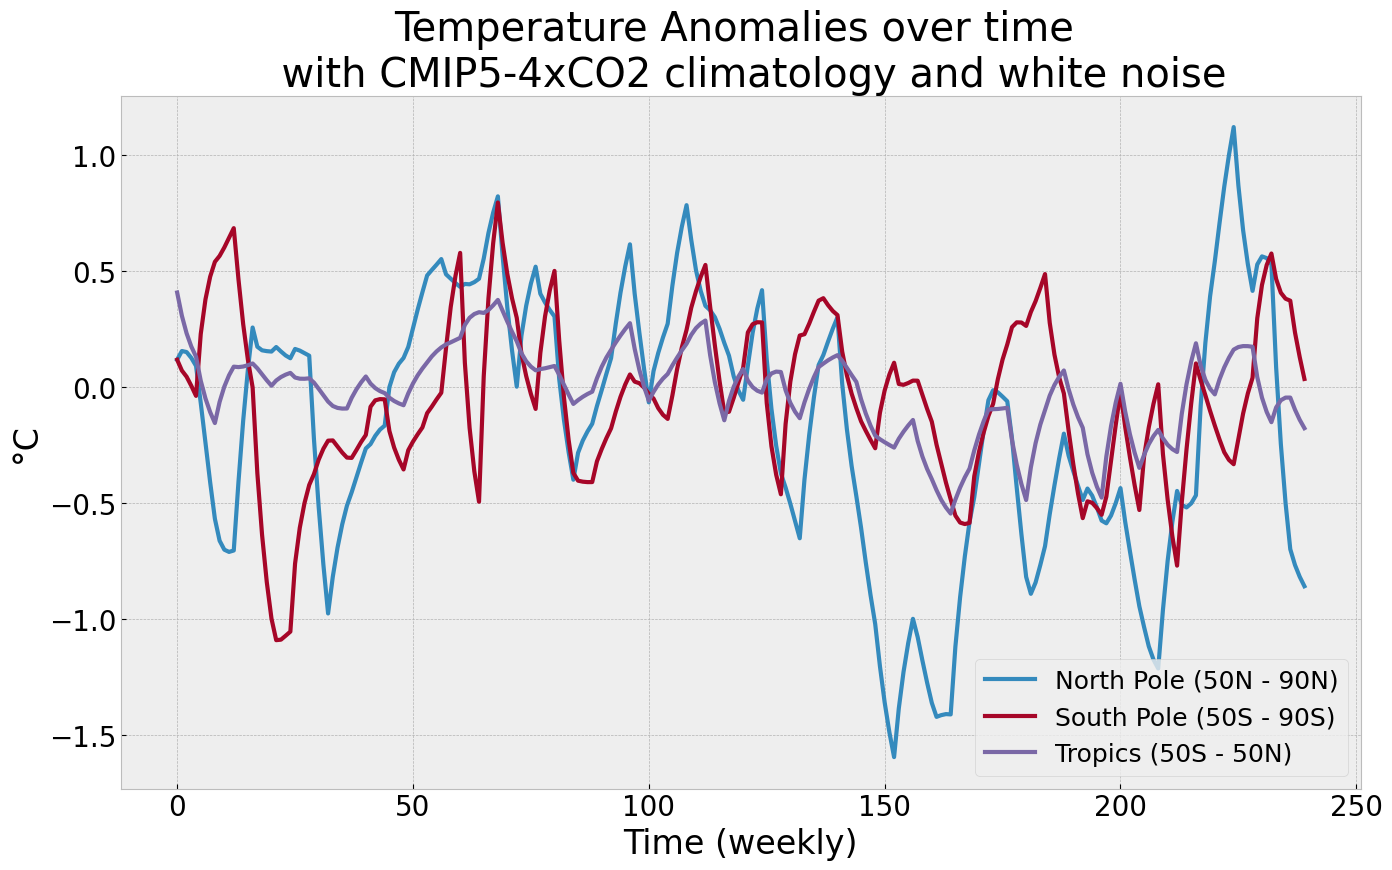

In [37]:
# T_save = np.array(T_save)
# T_SH = np.mean(T_save[:, :11], axis=1)
# T_NH = np.mean(T_save[:, -11:], axis=1)
# T_Tropics = np.mean(T_save[:, 11:-11], axis=1)

# Average temperature over specified regions
T_SH = np.average(T_save[:, :11], axis=1, weights=np.cos(np.pi*phi[:11]/180))
T_NH = np.average(T_save[:, -11:], axis=1, weights=np.cos(np.pi*phi[-11:]/180))
T_Tropics = np.average(T_save[:, 11:-11], axis=1, weights=np.cos(np.pi*phi[11:-11]/180))

# Plot temperature change over time in each region
plt.style.use('bmh')
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(16,9))
plt.title(f'Temperature Anomalies over time \n ' 
          + f' with {climatology} climatology and {noise_color} noise')
plt.plot(save_time, T_NH, lw=3, label="North Pole (50N - 90N)")
plt.plot(save_time, T_SH, lw=3, label="South Pole (50S - 90S)")
plt.plot(save_time, T_Tropics, lw=3, label="Tropics (50S - 50N)") # I KNOW, this goes into midtropics :/ 
plt.legend(loc='lower right', fontsize=18)
plt.xlabel(f"Time ({save_frequency:s})")
plt.ylabel("°C")
# plt.xlim(900,995)
# plt.gca().set_aspect(300)

# Calculate standard deviation of each time series
print(f"{'Standard Deviations of Temperature':^35s}")
print(f"{'':{'='}^35s}")
print(f"{'Northern Hemisphere:':25s} {np.std(T_NH):>7.3f}°C")
print(f"{'Southern Hemisphere:':25s} {np.std(T_SH):>7.3f}°C")
print(f"{'Tropics:':25s} {np.std(T_Tropics):>7.3f}°C")
# print("Already we see way more temperature variability in poles! \n")

Text(0, 0.5, 'g/kg')

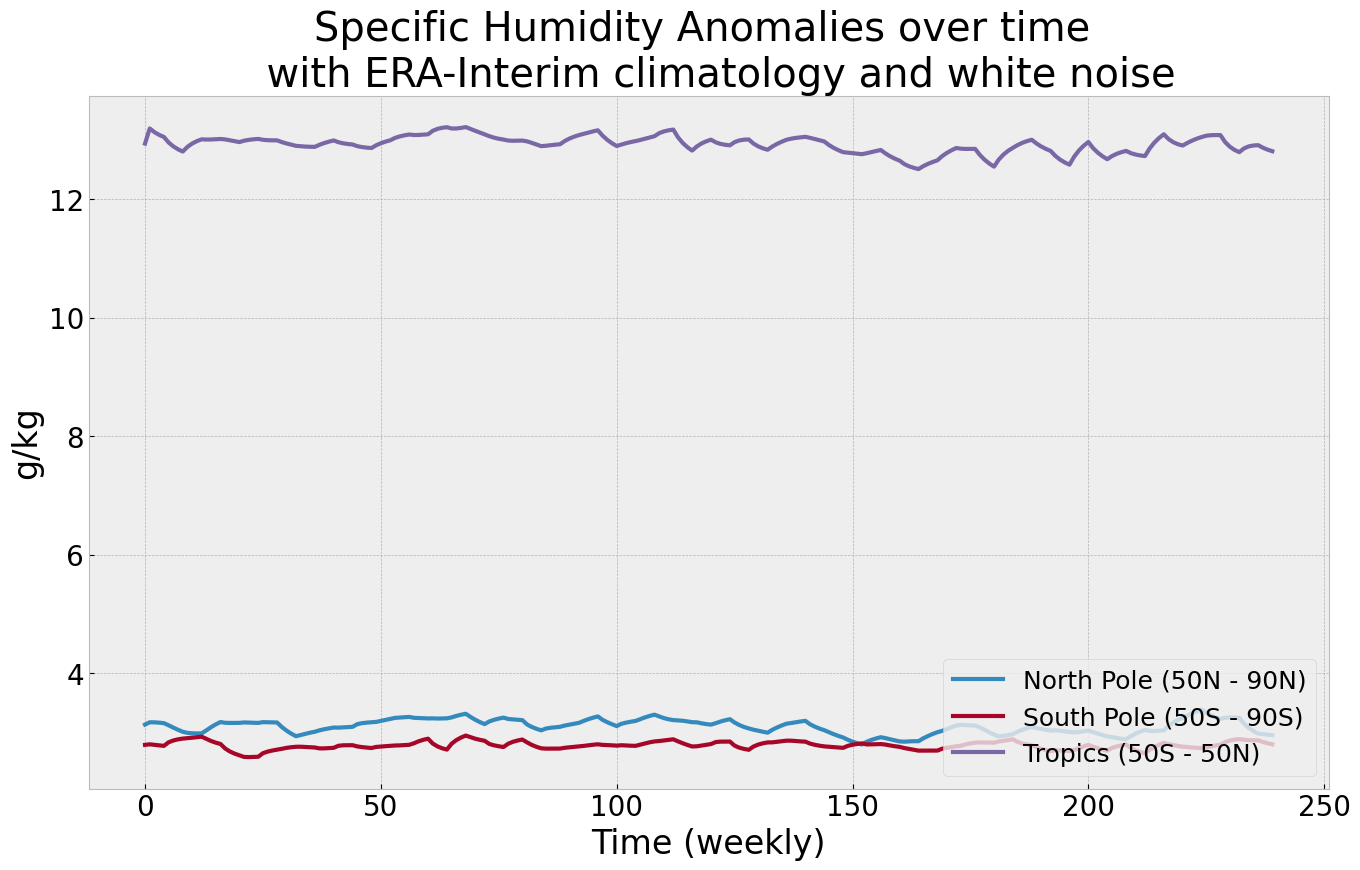

In [33]:

# Average temperature over specified regions
q_SH = np.average(q_save[:, :11], axis=1, weights=np.cos(np.pi*phi[:11]/180))
q_NH = np.average(q_save[:, -11:], axis=1, weights=np.cos(np.pi*phi[-11:]/180))
q_Tropics = np.average(q_save[:, 11:-11], axis=1, weights=np.cos(np.pi*phi[11:-11]/180))

# Plot temperature change over time in each region
plt.style.use('bmh')
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(16,9))
plt.title(f'Specific Humidity Anomalies over time \n ' 
          + f' with {climatology} climatology and {noise_color} noise')
plt.plot(save_time, 1000*q_NH, lw=3, label="North Pole (50N - 90N)")
plt.plot(save_time, 1000*q_SH, lw=3, label="South Pole (50S - 90S)")
plt.plot(save_time, 1000*q_Tropics, lw=3, label="Tropics (50S - 50N)")
plt.legend(loc='lower right', fontsize=18)
plt.xlabel(f"Time ({save_frequency:s})")
plt.ylabel("g/kg")
# plt.xlim(900,995)
# plt.gca().set_aspect(300)


## Plot temperature and specific humidity as a function of time and latitude

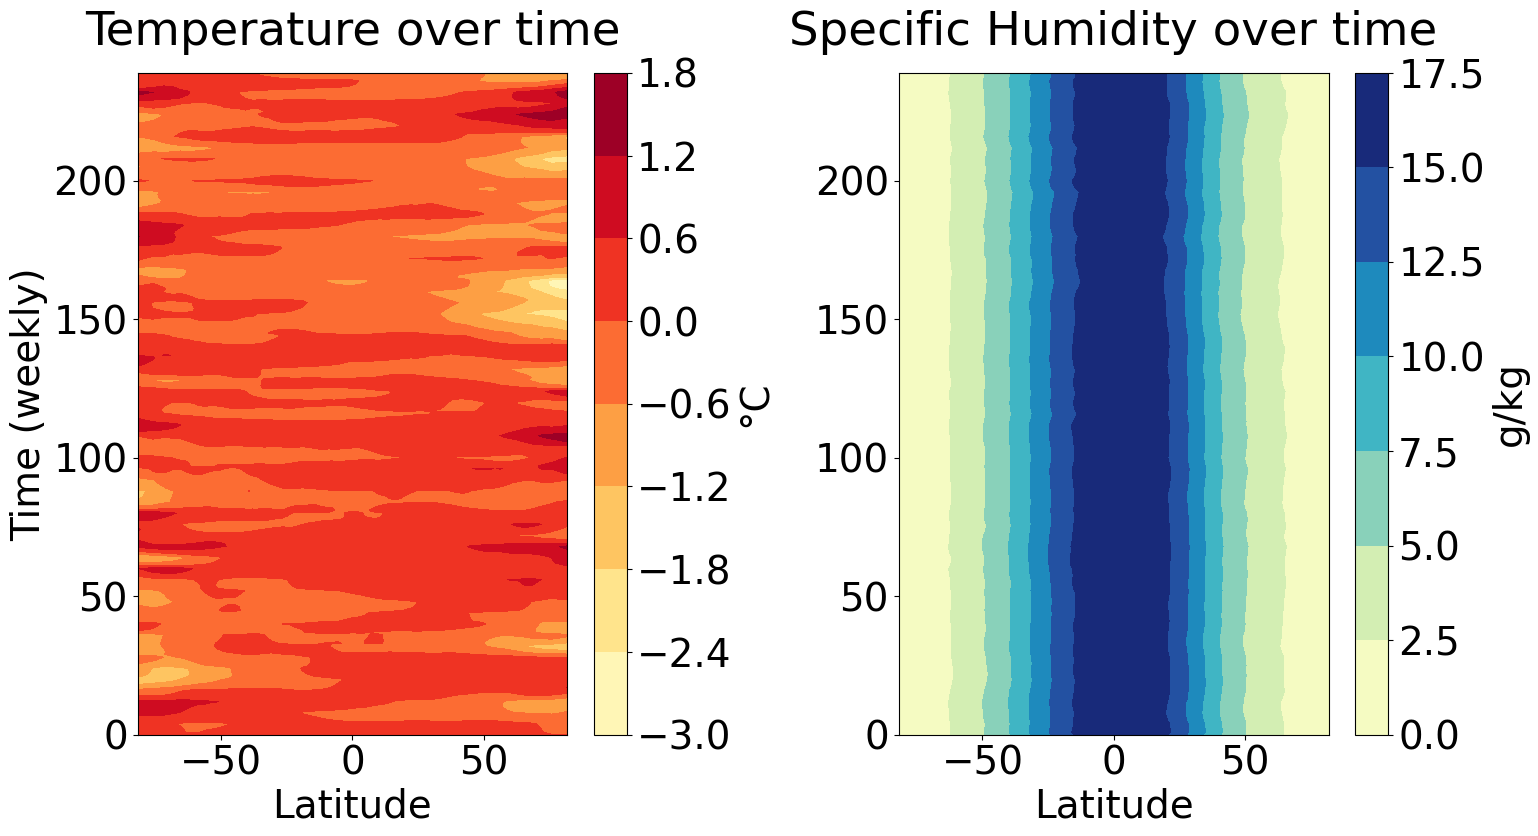

In [29]:
plt.style.use('default')
plt.rcParams.update({'font.size':28})

[fig, ax] = plt.subplots(1, 2, figsize=(16,9))
im0 = ax[0].contourf(phi, save_time, T_save, cmap='YlOrRd')
ax[0].set_title('Temperature over time', pad=20)
ax[0].set_xlabel('Latitude')
ax[0].set_ylabel(f'Time ({save_frequency:s})')
cbar = fig.colorbar(im0, ax=ax[0])
cbar.set_label('°C')
# ax.set_ylim(0, 100)

im1 = ax[1].contourf(phi, save_time, 1000*q_save, cmap='YlGnBu')
ax[1].set_title('Specific Humidity over time', pad=20)
ax[1].set_xlabel('Latitude')
cbar = fig.colorbar(im1, ax=ax[1])
cbar.set_label('g/kg')

plt.tight_layout()
plt.show()

## Plot standard deviation as a function of latitude

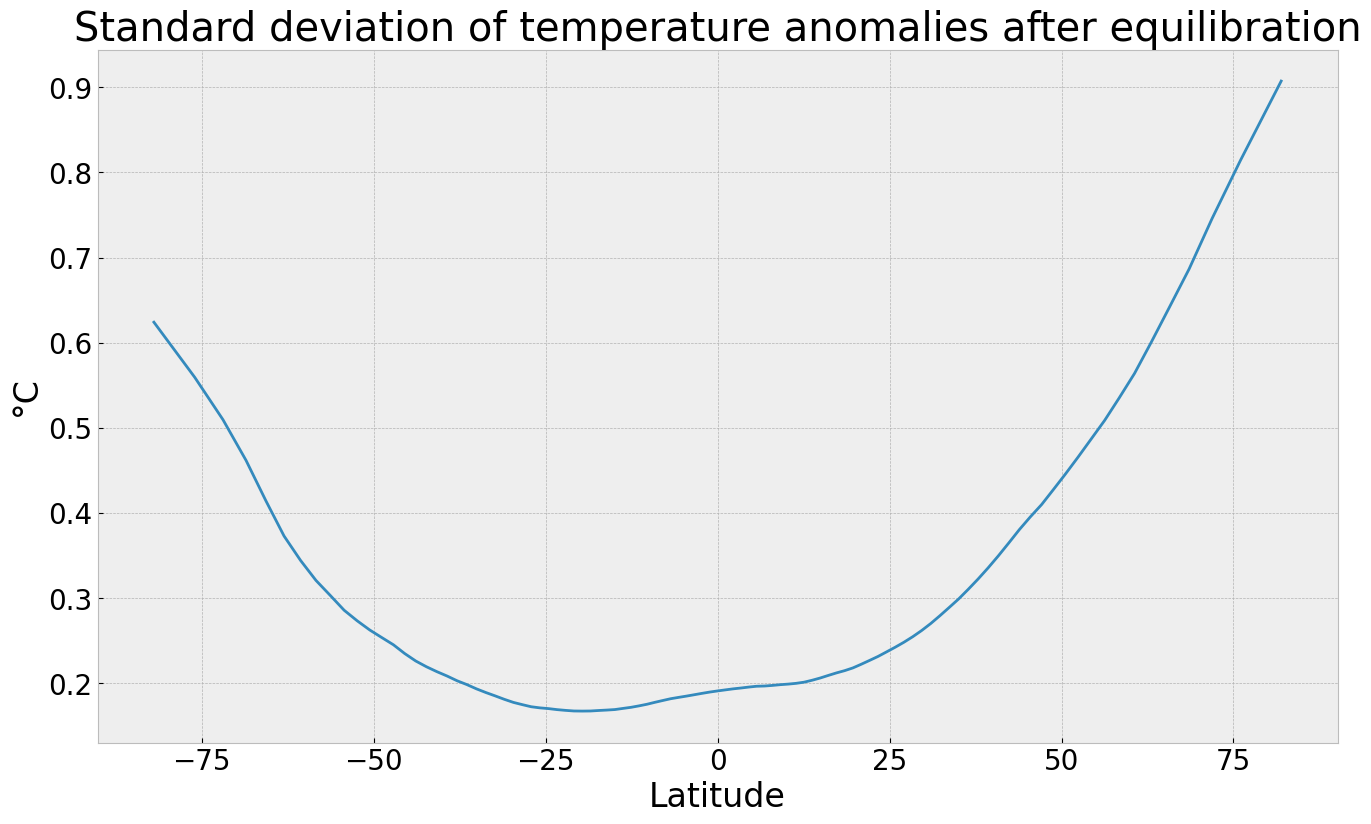

In [32]:
plt.style.use('bmh')
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(16,9))
plt.title(f'Standard deviation of temperature anomalies after equilibration')
plt.plot(phi, np.std(T_save, axis=0))
plt.xlabel("Latitude")
plt.ylabel("°C")
# plt.xlim(20,120)
# plt.gca().set_aspect(300)
plt.show()

## Plot forcing as a function of time and latitude

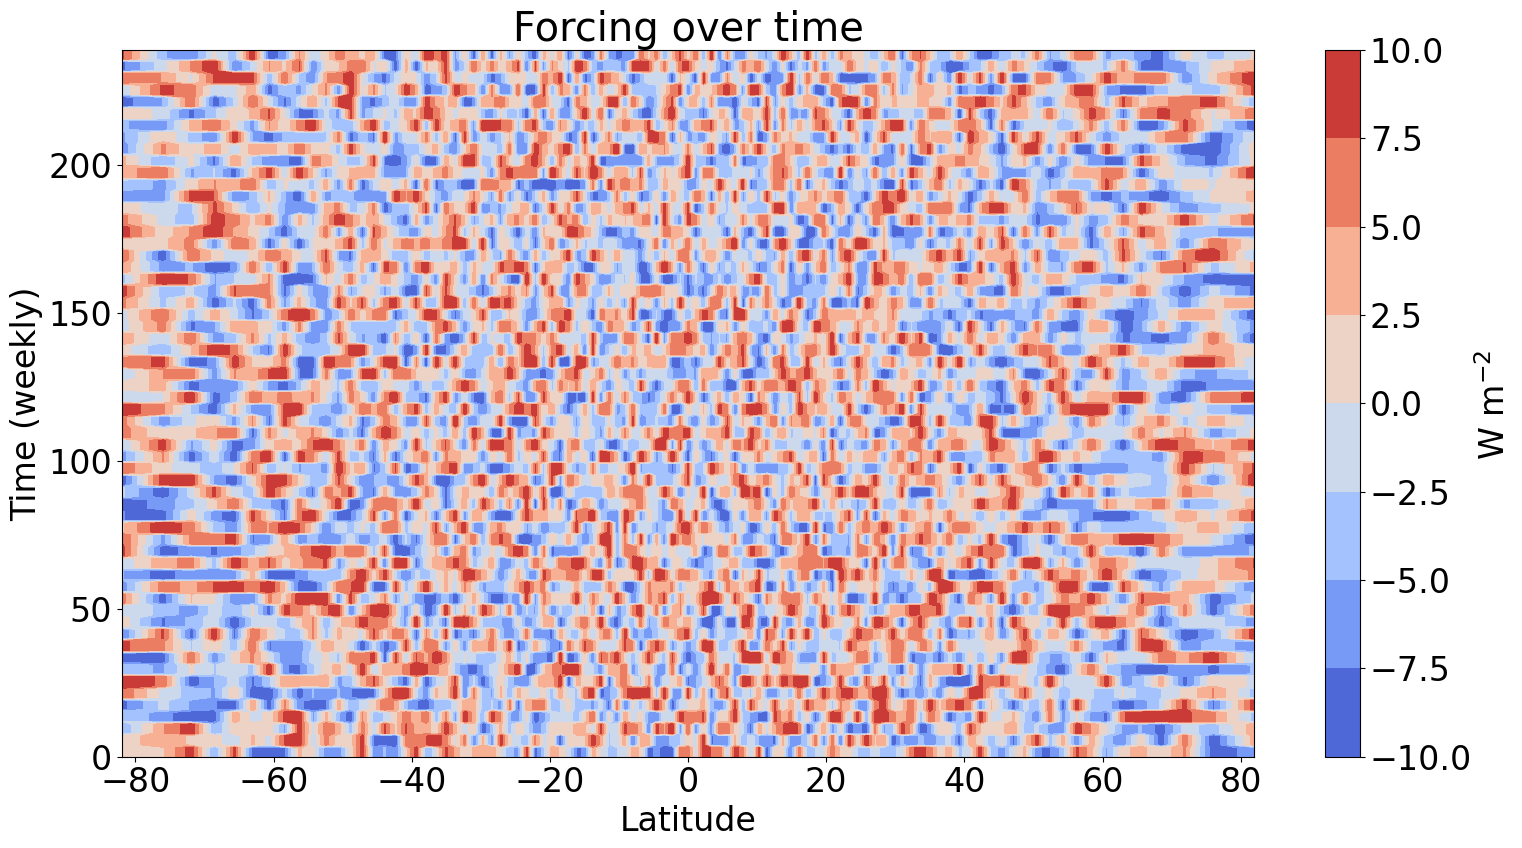

In [40]:
plt.style.use('default')
plt.rcParams.update({'font.size':24})
[fig, ax] = plt.subplots(figsize=(16,9))
im = ax.contourf(phi, save_time, R_frc_save, cmap='coolwarm', norm=colors.CenteredNorm())
ax.set_title('Forcing over time')
ax.set_xlabel('Latitude')
ax.set_ylabel(f'Time ({save_frequency:s})')
cbar = fig.colorbar(im, ax=ax)
cbar.set_label(r'W m$^{-2}$ ')
plt.tight_layout()
plt.show()

# Test Statistical Significance

## Standardize time series

In [41]:
def standardize_time_series(time_series):
    return (time_series - np.mean(time_series))/np.std(time_series)

In [42]:
# Standardize time series before calculating autocorrelation
T_NH_standardized = standardize_time_series(T_NH)
T_SH_standardized = standardize_time_series(T_SH)
T_Tropics_standardized = standardize_time_series(T_Tropics)

## Estimate autocorrelation and degrees of freedom

In [43]:
# Northern Hemisphere
autocorrelation_NH = np.sum(
            T_NH_standardized[1:] * T_NH_standardized[:-1]
        ) / (len(T_NH_standardized)-1)

degrees_of_freedom_NH = len(T_NH_standardized)*(
        1. - np.mean(autocorrelation_NH)**2
    ) / (1. + np.mean(autocorrelation_NH)**2)

# Southern Hemisphere
autocorrelation_SH = np.sum(
            T_SH_standardized[1:] * T_SH_standardized[:-1]
        ) / (len(T_SH_standardized)-1)

degrees_of_freedom_SH = len(T_SH_standardized)*(
        1. - np.mean(autocorrelation_SH)**2
    ) / (1. + np.mean(autocorrelation_SH)**2)

# Tropics
autocorrelation_Tropics = np.sum(
            T_Tropics_standardized[1:] * T_Tropics_standardized[:-1]
        ) / (len(T_Tropics_standardized)-1)

degrees_of_freedom_Tropics = len(T_Tropics_standardized)*(
        1. - np.mean(autocorrelation_Tropics)**2
    ) / (1. + np.mean(autocorrelation_Tropics)**2)

# Print summary table
print(f"{'Time Series Summary Statistics':^89s}")
print(f"{'':{'='}^88}")
print(f"{'|'}{'Region':^24}{'|'}{'Degrees of Freedom':^30}{'|'}{'Autocorrelation':^30}{'|'}")
print(f"{'':{'='}^88}")
print(f"{'|'}{'Northern Hemisphere':^24}{'|'}{degrees_of_freedom_NH:^30.0f}{'|'}{autocorrelation_NH:^30.3f}{'|'}")
print(f"{'|'}{'Southern Hemisphere':^24}{'|'}{degrees_of_freedom_SH:^30.0f}{'|'}{autocorrelation_SH:^30.3f}{'|'}")
print(f"{'|'}{'Tropics':^24}{'|'}{degrees_of_freedom_Tropics:^30.0f}{'|'}{autocorrelation_Tropics:^30.3f}{'|'}")
print(f"{'':{'='}^88}")

                             Time Series Summary Statistics                              
|         Region         |      Degrees of Freedom      |       Autocorrelation        |
|  Northern Hemisphere   |              7               |            0.973             |
|  Southern Hemisphere   |              15              |            0.938             |
|        Tropics         |              12              |            0.949             |


## Perform F-statistic test

In [44]:
f_critical_NH_SH = f.ppf(p_critical, degrees_of_freedom_NH, degrees_of_freedom_SH)
f_critical_NH_Tropics = f.ppf(p_critical, degrees_of_freedom_NH, degrees_of_freedom_Tropics)
f_critical_SH_Tropics = f.ppf(p_critical, degrees_of_freedom_SH, degrees_of_freedom_Tropics)

f_NH_SH = np.std(T_NH)**2/np.std(T_SH)**2
f_NH_Tropics = np.std(T_NH)**2/np.std(T_Tropics)**2
f_SH_Tropics = np.std(T_SH)**2/np.std(T_Tropics)**2

print(f"{'Statistical Significance Test Results':^66s}")
print(f"{'':{'='}^66s}")
print(f"{'|'}{'Region':^18s}{'|'}{'F Statistic':^22s}{'|'}{'F Critical':^22s}{'|'}")
print(f"{'':{'='}^66s}")
print(f'{"|"}{"NH & SH":^18s}{"|"}{f_NH_SH:^22.3f}{"|"}{f_critical_NH_SH:^22.3f}{"|"}')     
print(f'{"|"}{"NH & Tropics":^18s}{"|"}{f_NH_Tropics:^22.3f}{"|"}{f_critical_NH_Tropics:^22.3f}{"|"}')     
print(f'{"|"}{"SH & Tropics":^18s}{"|"}{f_SH_Tropics:^22.3f}{"|"}{f_critical_SH_Tropics:^22.3f}{"|"}')     
print(f"{'':{'='}^66s}")

if f_critical_NH_SH < f_NH_SH:
    print(f"✓  NH variability is statistically larger than " 
          + f"SH variability at the {100*p_critical:0.0f}% confidence level!")
else:
    print(f"X  NH variability is NOT statistically larger than " 
      + f"SH variability at the {100*p_critical:0.0f}% confidence level!")

if f_critical_NH_Tropics < f_NH_Tropics:
    print(f"✓  NH variability is statistically larger than " 
          + f"Tropical variability at the {100*p_critical:0.0f}% confidence level!")

else:
    print(f"X  NH variability is NOT statistically larger than " 
      + f"Tropical variability at the {100*p_critical:0.0f}% confidence level!")
    
if f_critical_SH_Tropics < f_SH_Tropics:
    print(f"✓  SH variability is statistically larger than " 
          + f"Tropical variability at the {100*p_critical:0.0f}% confidence level!")
    
else:
    print(f"X  SH variability is NOT statistically larger than " 
      + f"Tropical variability at the {100*p_critical:0.0f}% confidence level!")

              Statistical Significance Test Results               
|      Region      |     F Statistic      |      F Critical      |
|     NH & SH      |        2.596         |        2.712         |
|   NH & Tropics   |        9.274         |        2.901         |
|   SH & Tropics   |        3.572         |        2.568         |
X  NH variability is NOT statistically larger than SH variability at the 95% confidence level!
✓  NH variability is statistically larger than Tropical variability at the 95% confidence level!
✓  SH variability is statistically larger than Tropical variability at the 95% confidence level!


# Compute power spectra

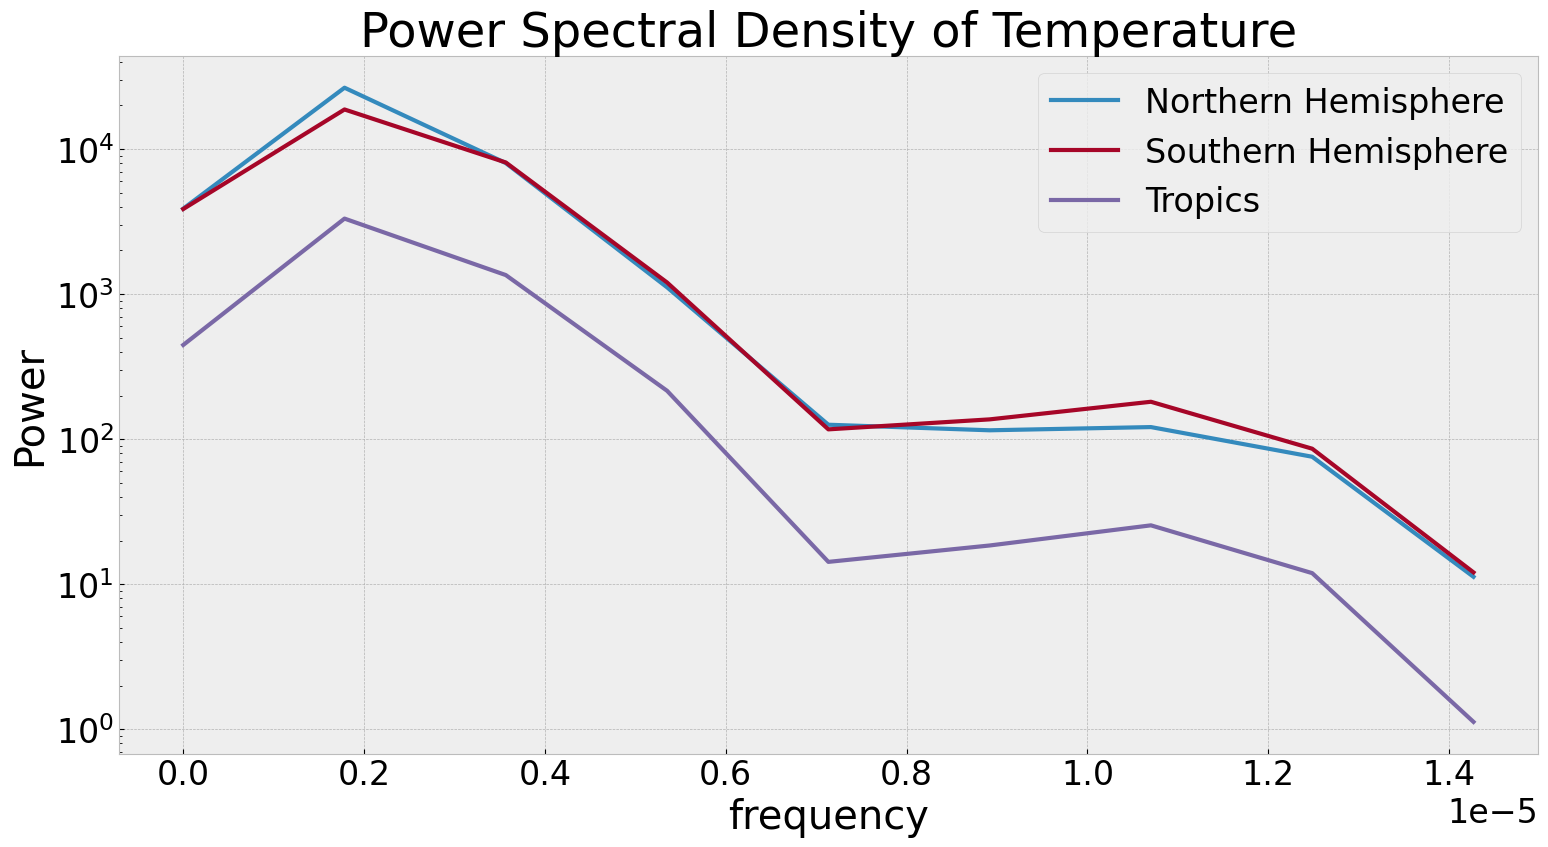

In [45]:
chunk_length = 16
(f_NH, S_NH) = welch(T_NH, delt, nperseg=chunk_length)
(f_SH, S_SH) = welch(T_SH, delt, nperseg=chunk_length)
(f_Tropics, S_Tropics) = welch(T_Tropics, delt, nperseg=chunk_length)

plt.style.use('bmh')
plt.figure(figsize=(16,9))
plt.title('Power Spectral Density of Temperature')
plt.semilogy(f_NH, S_NH, lw=3, label='Northern Hemisphere')
plt.semilogy(f_SH, S_SH, lw=3, label='Southern Hemisphere')
plt.semilogy(f_Tropics, S_Tropics, lw=3, label='Tropics')
plt.ylabel('Power')
plt.xlabel('frequency') 
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Compare temperature responses between scenarios

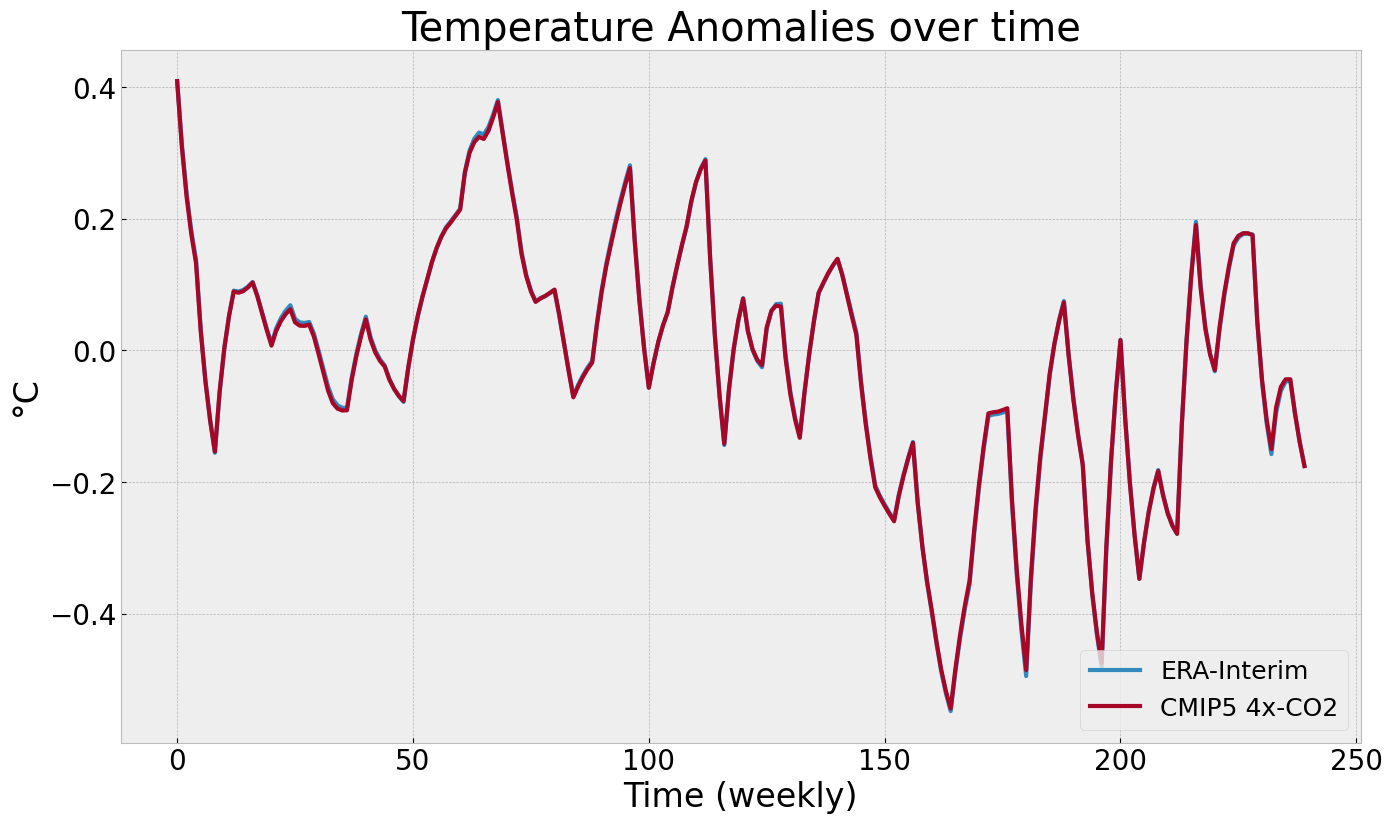

In [91]:
# ERA_interim_data = xr.open_dataset('simulation-output_ERA-Interim_no-noise_5-years_saved-weekly.nc')
# T_ERA = ERA_interim_data['T']

# CMIP5_data = xr.open_dataset('simulation-output_CMIP5-4xCO2_no-noise_5-years_saved-weekly.nc')
# T_CMIP5 = CMIP5_data['T']

# T_ERA = np.average(T_ERA[:, -11:], axis=1, weights=np.cos(np.pi*phi[-11:]/180))
# T_CMIP5 = np.average(T_CMIP5[:, -11:], axis=1, weights=np.cos(np.pi*phi[-11:]/180))


# ERA_interim_data_noise = xr.open_dataset('simulation-output_ERA-Interim_white-noise_5-years_saved-weekly.nc')
# T_ERA_noise = ERA_interim_data_noise['T']

# CMIP5_data_noise = xr.open_dataset('simulation-output_CMIP5-4xCO2_white-noise_5-years_saved-weekly.nc')
# T_CMIP5_noise = CMIP5_data_noise['T']

# T_ERA_noise = np.average(T_ERA_noise[:, -11:], axis=1, weights=np.cos(np.pi*phi[-11:]/180))
# T_CMIP5_noise = np.average(T_CMIP5_noise[:, -11:], axis=1, weights=np.cos(np.pi*phi[-11:]/180))

ERA_interim_data = xr.open_dataset('ERA_interim.nc')
T_ERA = ERA_interim_data['T']

CMIP5_data = xr.open_dataset('CMIP5.nc')
T_CMIP5 = CMIP5_data['T']

T_ERA = np.average(T_ERA[:, 11:-11], axis=1, weights=np.cos(np.pi*phi[11:-11]/180))
T_CMIP5 = np.average(T_CMIP5[:, 11:-11], axis=1, weights=np.cos(np.pi*phi[11:-11]/180))


# Plot temperature change over time in each region
plt.style.use('bmh')
plt.rcParams.update({'font.size':20})
plt.figure(figsize=(16,9))
plt.title(f'Temperature Anomalies over time')
plt.plot(save_time, T_ERA, lw=3, color='#348ABD', label="ERA-Interim")
plt.plot(save_time, T_CMIP5, lw=3, color='#A60628', label="CMIP5 4x-CO2")

# plt.plot(save_time, T_ERA_noise, ls='--', lw=3, color='#348ABD', label="ERA-Interim, noise")
# plt.plot(save_time, T_CMIP5_noise, ls='--', lw=3, color='#A60628', label="CMIP5 4x-CO2, noise")
plt.legend(loc='lower right', fontsize=18)
plt.xlabel(f"Time ({save_frequency:s})")
plt.ylabel("°C")
plt.show()

# OLD CODE

The global mean surface temperature has increased by:  0.02752094046359688


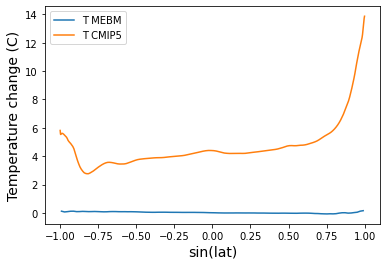

In [23]:
print("The global mean surface temperature has increased by: ", np.mean(T)) #temperature anomaly
plt.plot(x,T, label="T MEBM")
plt.plot(np.sin(np.deg2rad(CMIP5_lat)),np.mean(CMIP5_T,axis=1), label="T CMIP5") #compare to CMIP5 average warming
plt.xlabel('sin(lat)', fontsize=14)
plt.ylabel('Temperature change (C)', fontsize=14)
plt.legend()
plt.show()

In [24]:
divF_pert = -np.matmul(Mdiv,theta_e_pert);
h_pert = theta_e_pert*cp;

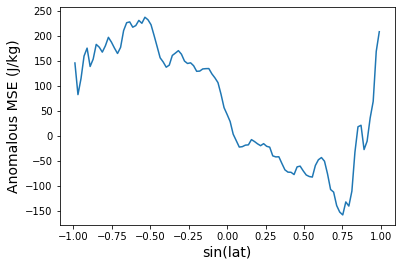

In [25]:
plt.plot(x,h_pert)
plt.xlabel('sin(lat)', fontsize=14)
plt.ylabel('Anomalous MSE (J/kg)', fontsize=14)
plt.show()

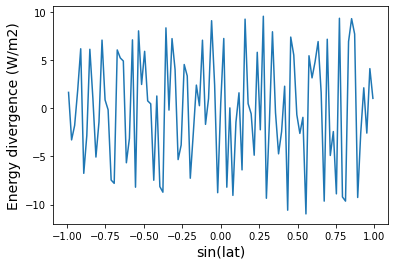

In [26]:
plt.plot(x,divF_pert)
plt.xlabel('sin(lat)', fontsize=14)
plt.ylabel('Energy divergence (W/m2)', fontsize=14)
plt.show()

In [27]:
# Module to calculate terms in hyrological cycle

q_expt = q; #sorry not sorry for all the ;s
q_pert = q_expt-q_ctrl;
divF_pert = -Mdiv*theta_e_pert;
h_pert = theta_e_pert*cp;
T_pert = T;
T_expt = T+T_ctrl;

# define some things from the climatology first 

Re = 6.4e6;                 # [m] earth's radius
rho = 1e3;                  # [kg m-3] density

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.mlab as mlab
import math

wt = 1-mlab.normpdf(x, 0, np.sin(15*2*np.pi/360))/mlab.normpdf(0, 0, np.sin(15*2*np.pi/360)) # define Gaussian Hadley Cell width wt = 1-gaussmf(x,[sind(15) 0]);


AttributeError: module 'matplotlib.mlab' has no attribute 'normpdf'

In [ ]:
# calculate some things about the control climate (ctrl)

Dhlf = Dmag*np.ones(jmx);                                   # [W m-2 K-1] calculate D on same grid as T,q, etc ##0.5*(D(1:end-1)+D(2:end));  #WARNING: would need to modify this if allowing D to vary with latitude
h_ctrl = cp*(T_ctrl+273.15)+L*q_ctrl;                       # [J kg-1] control climate mse
F_ctrl = -2*np.pi*np.square(Re)/cp*Dhlf*(1-np.square(x))*np.gradient(h_ctrl,x);  # [W] control climate flux 
F_lh_ctrl = -2*np.pi*np.square(Re)/cp*Dhlf*(1-np.square(x))*np.gradient(L*q_ctrl,x);    # [W] control latent heat flux
F_hc_ctrl = (1-wt)*F_ctrl;                                 # [W] Hadley Cell Flux
heq_ctrl = h_ctrl[50];                                 #value at equator WARNING will have to change if change grid ; # [J kg-1] moist static energy at the surface
V_ctrl = F_hc_ctrl/(heq_ctrl*1.06-h_ctrl);               # [kg s-1] Diagnosed mass transport in Hadley Cell (Nick's way)

F_LH_ctrl = -L*V_ctrl*q_ctrl + wt*F_lh_ctrl;              # [W] latent heat (Hadley plus eddy)
F_LH_eddy_ctrl = wt*F_lh_ctrl;                         # eddy latent heat fluxes including weighting function.
divF_LH_ctrl = 1/(2*np.pi*np.square(Re))*np.gradient(F_LH_ctrl,x);         # [W m-2] divergence of latent heat flux
E_m_P_ctrl = divF_LH_ctrl/(L*rho)*np.pi*1e7;                   # [m yr-1]E-P

# code from Nick Siler to partition E-P;
alpha=L/461.5/np.square(T_ctrl+273.15);                         # Nick's alpha parameter
beta=cp/L/alpha/q_ctrl;                                   # beta parameter
RG=180*(1*(1-np.square(x))-.4*np.exp(-np.square((x/.15))));                   # [W m-2] idealized R-G
Ch=1.5e-3;                                                  # drag coefficient
LWfb=0;                                                     # LW feedback at surface, in W/m2/K
u=4+np.abs(np.sin(np.pi*x/1.5))*4; #-2.5*cos(3*np.arcsin(x));     # wind speed
rho_air=1.2;       #psfc/287/(T_ctrl+273.15);               # air density
E_ctrl=(RG*alpha+rho_air*cp*(1-relhum)*Ch*u)/(alpha+cp/L/q_ctrl);
P_ctrl=E_ctrl-divF_LH_ctrl;
# P_ctrl=P_ctrl/(L*rho)*np.pi*1e7; # [m yr-1]
# E_ctrl=E_ctrl/(L*rho)*np.pi*1e7; # [m yr-1]

In [ ]:
# calculate some things about the new climate state (expt)

h_expt = h_ctrl+h_pert;                                 # [J kg-1] new total mse
F_expt = -2*np.pi*np.square(Re)/cp*Dhlf*(1-np.square(x))*np.gradient(h_expt,x);      # [W] new total flux
F_lh_expt = -2*np.pi*np.square(Re)/cp*Dhlf*(1-np.square(x))*np.gradient(L*q_expt,x);    # [W] control latent heat flux
F_hc_expt = (1-wt)*F_expt;                             # [W] Hadley Cell Flux
heq_expt = h_expt[50];                                # [J kg-1] moist static energy at the surface
V_expt = F_hc_expt/(heq_expt*1.06-h_expt);           # [wkg s-1] Diagnosed mass transport in Hadley Cell

F_LH_expt = -L*V_expt*q_expt + wt*F_lh_expt;          # [W] latent heat (Hadley plus eddy)
F_LH_eddy_expt = wt*F_lh_expt;                         # eddy latent heat fluxes including weighting function.
divF_LH_expt = 1/(2*np.pi*np.square(Re))*np.gradient(F_LH_expt,x);      # [W m-2]
E_m_P_expt = divF_LH_expt/(L*rho)*np.pi*1e7;               # [m yr-1] E-P

alpha=L/461.5/np.square(T_expt+273.15);                         # Nick's alpha parameter
beta=cp/L/alpha/q_expt;                                   # beta parameter
#E_expt=(RG*alpha+rho_air*cp*(1-relhum)*Ch*u)/(alpha+cp/L/q_expt);
#P_expt=E_expt-divF_LH_expt;
#P_expt=P_expt/(L*rho)*np.pi*1e7; # [m yr-1]
#E_expt=E_expt/(L*rho)*np.pi*1e7; # [m yr-1] 

#ok, change implemented by GHR Mar
#E_expt=(RG.*alpha+rho_air.*cp.*(1-relhum).*Ch.*u)./(alpha+cp./L./q_expt);
# Equation 16 from Siler et al. (JClim,2018)
Rv = 461; #gas constant for H20 vapor
alf = L/(Rv*np.square(T_ctrl+273.15)); # Clausius-Clapeyron scaling 1/q*dq/dT
beta = cp/(alf*q_ctrl*L); # Bowen ratio

E_pert = (E_ctrl*T_pert*beta*(alf-2/(T_ctrl+273.15))-G_frc)/(1+beta);
E_expt = E_ctrl+E_pert;

P_expt=E_expt-divF_LH_expt;

# convert from Wm-2 to m yr-1
P_ctrl=P_ctrl/(L*rho)*np.pi*1e7; # [m yr-1]
E_ctrl=E_ctrl/(L*rho)*np.pi*1e7; # [m yr-1]
P_expt=P_expt/(L*rho)*np.pi*1e7; # [m yr-1]
E_expt=E_expt/(L*rho)*np.pi*1e7; # [m yr-1] 


In [ ]:
# Figures for climatology prior to perturbation

plt.plot(x,T_ctrl)
plt.xlabel('sin(lat)', fontsize=14)
plt.ylabel('Temperature (C)', fontsize=14)
plt.show()

plt.plot(x,F_ctrl) #total heat transport
plt.plot(x,F_ctrl-F_LH_ctrl) #dry
plt.plot(x,F_LH_ctrl) #latent
plt.xlabel('sin(lat)', fontsize=14)
plt.ylabel('Northward heat flux (PW)', fontsize=14)
plt.show()

plt.plot(x,F_LH_ctrl) #latent heat transport
plt.plot(x,F_LH_eddy_ctrl) #eddy component of latent
plt.plot(x,-L*V_ctrl*q_ctrl) #Hadley cell component of latent 
plt.xlabel('sin(lat)', fontsize=14)
plt.ylabel('Northward heat flux (PW)', fontsize=14)
plt.show()

plt.plot(x,E_m_P_ctrl) #latent heat transport
plt.plot(x,E_ctrl) #eddy component of latent
plt.plot(x,P_ctrl) #Hadley cell component of latent 
plt.xlabel('sin(lat)', fontsize=14)
plt.ylabel('Evap, precip', fontsize=14)
plt.show()


In [ ]:
# Figures for perturbation

plt.plot(x,T)
plt.xlabel('sin(lat)', fontsize=14)
plt.ylabel('Temperature change (C)', fontsize=14)
plt.show()

plt.plot(x,F_expt-F_ctrl) #total heat transport
plt.plot(x,(F_expt-F_LH_expt) - (F_ctrl-F_LH_ctrl)) #dry
plt.plot(x,F_LH_expt - F_LH_ctrl) #latent
plt.xlabel('sin(lat)', fontsize=14)
plt.ylabel('Northward heat flux changes (PW)', fontsize=14)
plt.show()

plt.plot(x,F_LH_expt - F_LH_ctrl) #latent heat transport
plt.plot(x,F_LH_eddy_expt - F_LH_eddy_ctrl) #eddy component of latent
plt.plot(x,-L*V_expt*q_expt - (-L*V_ctrl*q_ctrl)) #Hadley cell component of latent 
plt.xlabel('sin(lat)', fontsize=14)
plt.ylabel('Northward heat flux anomaly (PW)', fontsize=14)
plt.show()

plt.plot(x,E_m_P_expt - E_m_P_ctrl) #latent heat transport
plt.plot(x,E_expt - E_ctrl) #eddy component of latent
plt.plot(x,P_expt - P_ctrl) #Hadley cell component of latent 
plt.xlabel('sin(lat)', fontsize=14)
plt.ylabel('Evap, precip changes', fontsize=14)
plt.show()